In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

random.seed(1904)

## Expectation Maximization (EM) Algorithm for Gaussian Mixtures

The following cells are direct implementations of EM for Gaussian mixtures as described in Bishop 2006 pages 438-439. Each line in the book precedes the function that implements it.  

Initialize the means $\mu_k$, covariances $\sigma_k$ and mixing coefﬁcients $\pi_k$

In [2]:
def initialize_mu(data, num_clusters):
    mu = data[np.random.choice(data.shape[0], num_clusters, replace=False)]
    return mu

In [3]:
def initialize_sigma(data, num_clusters):
    D = data.shape[1]
    sigma = np.zeros((num_clusters, D, D))
    
    for k in range(num_clusters):
        for d in range(D):
            sigma[k, d, d] = 1
    
    return sigma

In [4]:
def initialize_pi(num_clusters):
    pi = np.full(num_clusters, 1/num_clusters)

    return pi

### E step
Evaluate the responsibilities using the current parameter values

$$
\gamma(z_{nk}) = \frac{\pi_k \mathcal{N}(x_n \mid \mu_k, \sigma_k)}{\sum_{j = 1}^K \pi_j \mathcal{N}(x_n \mid \mu_j, \sigma_j)}
$$

In [5]:
def E_step(data, mu, sigma, pi):
    K = pi.shape[0]
    N = data.shape[0]
    gamma_z = np.zeros((K, N))
    for k in range(K):
        gamma_z[k, :] = pi[k] * multivariate_normal.pdf(data, mean = mu[k], cov = sigma[k])
    
    gamma_z /= gamma_z.sum(0)
    
    return gamma_z

### M step
Re-estimate the parameters using the current responsibilities

$$ 
\begin{align*} 
\mu_k^{\text{new}} &= \frac{1}{N_k}\sum_{n = 1}^N \gamma(z_{nk})x_n \\ 
\sigma_k^{\text{new}} &= \frac{1}{N_k}\sum_{n = 1}^N \gamma(z_{nk})(x_n - \mu_k^{\text{new}})(x_n - \mu_k^{\text{new}})^T \\
\pi_k^{\text{new}} &= \frac{N_k}{N}
\end{align*} 
$$

where
$$
N_k = \sum_{n = 1}^N \gamma (z_{nk})
$$

In [6]:
def M_step(data, mu, sigma, gamma_z):
    mu_new = np.zeros(mu.shape)
    sigma_new = np.zeros(sigma.shape)
    pi_new = np.zeros(mu.shape[0])
    for k in range(gamma_z.shape[0]):
        N = data.shape[0]
        total_k = sum(gamma_z[k])
        gamma_zk = gamma_z[k].reshape(-1, 1)
        mu_new[k] = sum(gamma_zk * data)/total_k
        for n in range(N):
            sigma_new[k] += gamma_z[k, n] * np.dot((data[n, :] - mu_new[k]).reshape(-1,1), (data[n, :] - mu_new[k]).reshape(1,-1))
        sigma_new[k] /= total_k
        pi_new[k] = total_k/N
    
    return (mu_new, sigma_new, pi_new)

Evaluate the log likelihood

$$
\ln p(X \mid \mu, \sigma, \pi) = \sum_{n = 1}^N \ln \left \{ \sum_{k = 1}^K \pi_k \mathcal{N} (x_n \mid \mu_k, \sigma_k ) \right\}
$$

In [7]:
def eval_log_likelihood(data, mu, sigma, pi):
    K = pi.shape[0]
    N = data.shape[0]
    ln_p = 0
    for n in range(N):
        p_n = 0
        for k in range(K):
            p_n += pi[k] * multivariate_normal.pdf(data[n], mean = mu[k], cov = sigma[k])
    ln_p += np.log(p_n)
    return ln_p

In [8]:
def initialize_params(data, num_clusters):
    return (initialize_mu(data, num_clusters), initialize_sigma(data, num_clusters), initialize_pi(num_clusters))

In [9]:
class gaussian_params():
    def __init__(self, mu, cov, size):
        self.mu = mu
        self.cov = cov
        self.size = size

In [10]:
def get_data_3d(params):
    data_x = []
    data_y = []
    data_z = []
    for param in params:
        x, y, z = np.random.multivariate_normal(mean=param.mu, cov=param.cov, size=param.size).T
        data_x.extend(x)
        data_y.extend(y)
        data_z.extend(z)
    data = np.c_[data_x, data_y, data_z]
    
    return data

In [11]:
def get_data(params):
    data_x = []
    data_y = []
    for param in params:
        x, y = np.random.multivariate_normal(mean=param.mu, cov=param.cov, size=param.size).T
        data_x.extend(x)
        data_y.extend(y)
    data = np.c_[data_x, data_y]
    
    return data

In [12]:
def plot_cluster(data, mu, sigma, gamma_z, epoch):
    ax = plt.gca()
    colors = []
    for x in range(len(data)):
        colors.append((gamma_z[0, x], 0, gamma_z[1, x]))
    ax.scatter(data[:,0], data[:,1], c = colors)
    ax.set_title(f"Epoch: {epoch}")
    K = mu.shape[0]
    
    for k in range(K): 
        lambda_, v = np.linalg.eig(sigma[k])
        lambda_ = np.sqrt(lambda_)
        cluster = Ellipse(xy=(mu[k, 0], mu[k, 1])
                             , width = lambda_[0]*2
                             , height= lambda_[1]*2
                             , angle = np.rad2deg(np.arccos(v[0, 0]))
                             , color = 'black')
        cluster.set_facecolor('none')
        ax.add_artist(cluster)
    
    plt.show()

In [13]:
def plot_cluster_3d(data, mu, sigma, gamma_z, epoch):
    K = mu.shape[0]
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = []
    for x in range(len(data)):
        colors.append((gamma_z[0, x], 0, gamma_z[1, x]))
    ax.scatter(data[:,0], data[:,1], data[:, 2], c = colors)
    for k in range(K):
        ax.plot([mu[k, 0]], [mu[k, 1]], [mu[k, 2]], c='yellow', markersize=20, marker='o')
    ax.set_title(f"Epoch: {epoch}")

In [14]:
def EM_2d(data, K):
    plt.scatter(data[:,0], data[:,1], c = 'purple')
    plt.title("Initial Data")
    plt.show()
    (mu, sigma, pi) = initialize_params(data, K)
    prev_likelihood = eval_log_likelihood(data, mu, sigma, pi)
    for epoch in range(10000):
        gamma_z = E_step(data, mu, sigma, pi)
        plot_cluster(data, mu, sigma, gamma_z, epoch)
        (mu, sigma, pi) = M_step(data, mu, sigma, gamma_z)
        log_likelihood = eval_log_likelihood(data, mu, sigma, pi)
        print(f"log_likelihood: {log_likelihood}")
        if(abs(log_likelihood - prev_likelihood) < 0.00001):
            break
        prev_likelihood = log_likelihood

In [15]:
def EM_3d(data, K):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c = 'purple')
    ax.set_title('Initial Data')
    (mu, sigma, pi) = initialize_params(data, K)
    prev_likelihood = eval_log_likelihood(data, mu, sigma, pi)
    for epoch in range(1000):
        gamma_z = E_step(data, mu, sigma, pi)
        plot_cluster_3d(data, mu, sigma, gamma_z, epoch)
        (mu, sigma, pi) = M_step(data, mu, sigma, gamma_z)
        log_likelihood = eval_log_likelihood(data, mu, sigma, pi)
        print(f"log_likelihood: {log_likelihood}")
        if(abs(log_likelihood - prev_likelihood) < 0.00001):
            break
        prev_likelihood = log_likelihood

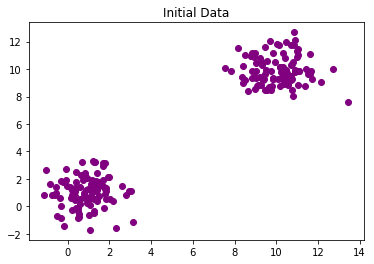

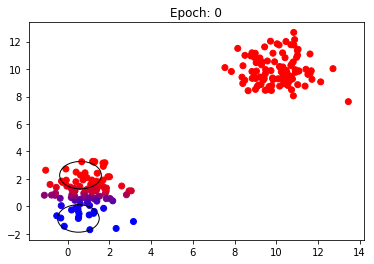

log_likelihood: -5.237682960390254


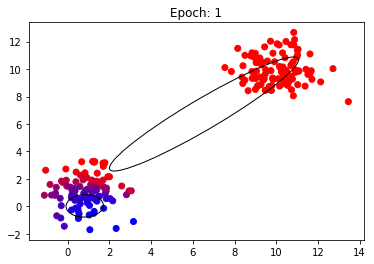

log_likelihood: -5.190592687003714


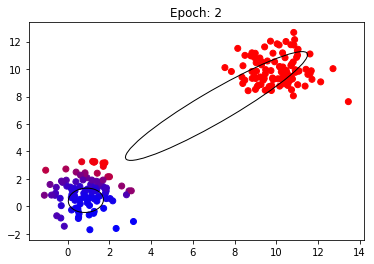

log_likelihood: -5.085746422580585


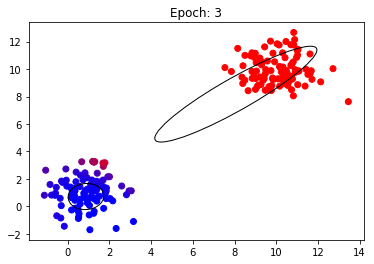

log_likelihood: -4.840088623564822


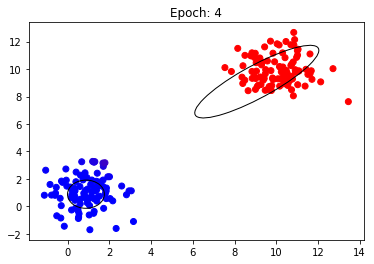

log_likelihood: -4.096641344785342


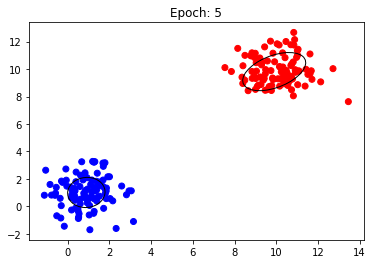

log_likelihood: -3.5639334967925915


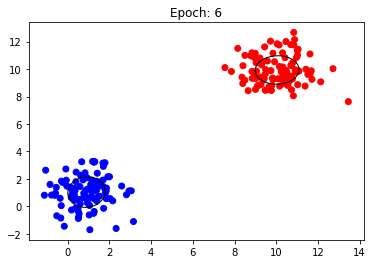

log_likelihood: -3.563933313770025


In [23]:
cluster1 = gaussian_params([1,1], [[1, 0], [0, 1]], 100)
cluster2 = gaussian_params([10,10], [[1, 0], [0, 1]], 100)
params = [cluster1, cluster2]

data = get_data(params)
EM(data, 2)

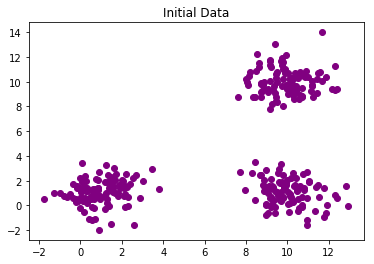

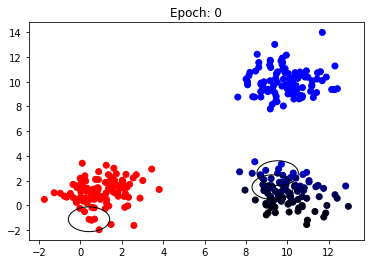

log_likelihood: -4.642424414955194


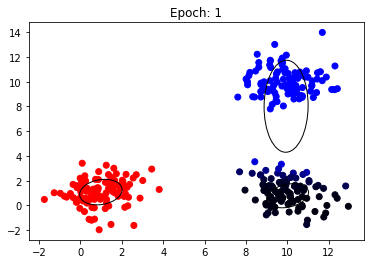

log_likelihood: -4.903926760199077


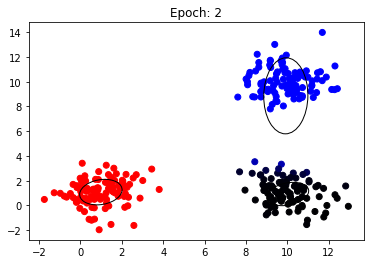

log_likelihood: -4.94623081644634


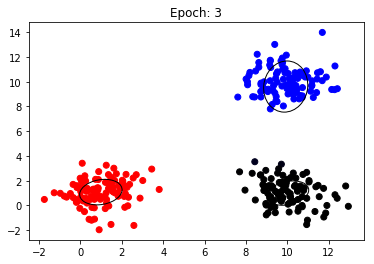

log_likelihood: -4.643282496289707


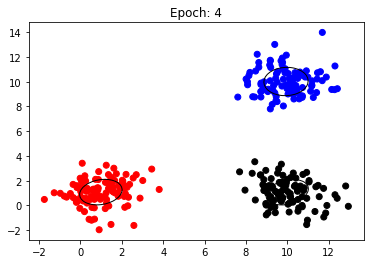

log_likelihood: -4.6174910468195165


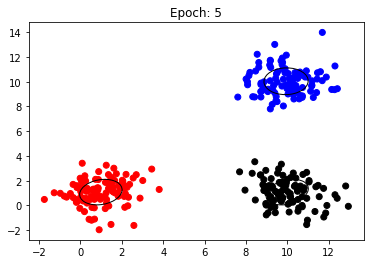

log_likelihood: -4.617490902975866


In [17]:
cluster1 = gaussian_params([1,1], [[1, 0], [0, 1]], 100)
cluster2 = gaussian_params([10,10], [[1, 0], [0, 1]], 100)
cluster3 = gaussian_params([10,1], [[1, 0], [0, 1]], 100)
params = [cluster1, cluster2, cluster3]

data = get_data(params)
EM(data, 3)

In [ ]:
#TODO: Calculate square distance from calculated mean to actual means. 
# Also, plot both actual means and covariances. 
# Compare likelihood from sample data (initial parameters) to what is generated. 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


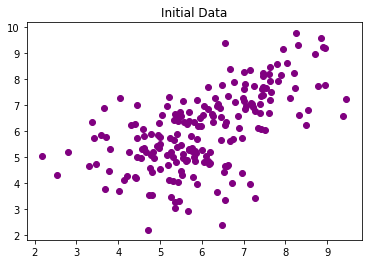

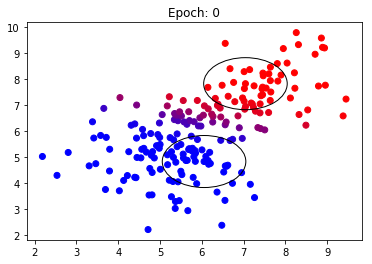

log_likelihood: -3.1781959670667255


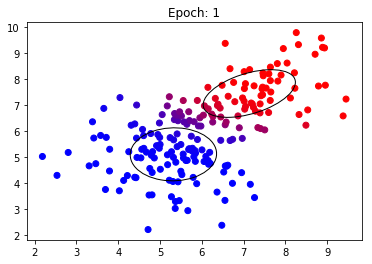

log_likelihood: -3.176367598849258


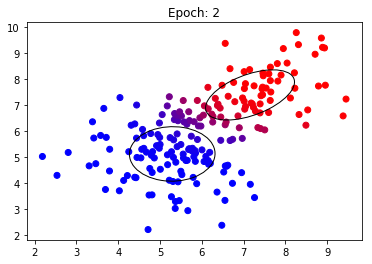

log_likelihood: -3.178027723072734


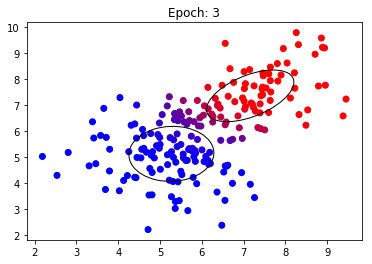

log_likelihood: -3.1806225970251996


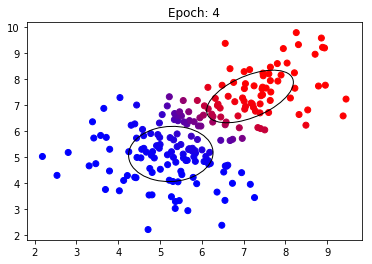

log_likelihood: -3.1836962111505858


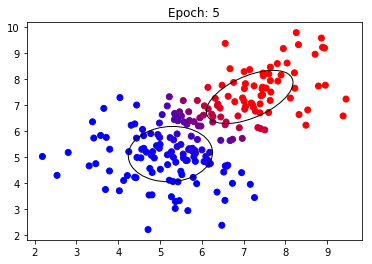

log_likelihood: -3.1869545078484114


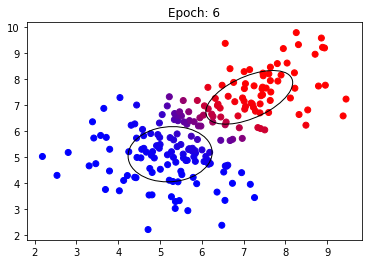

log_likelihood: -3.1902143672068246


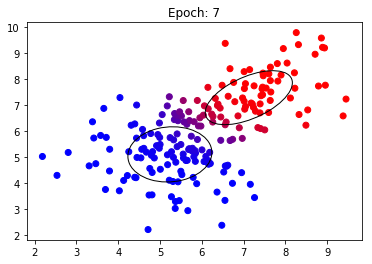

log_likelihood: -3.193385412109734


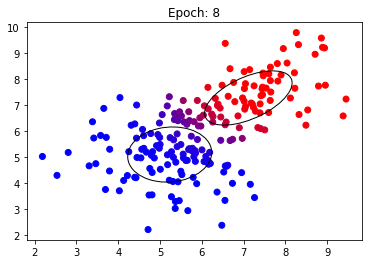

log_likelihood: -3.196432622998799


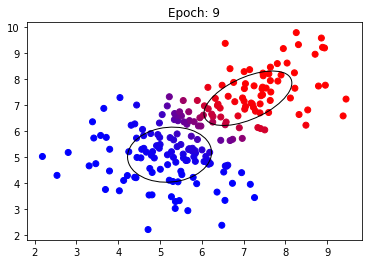

log_likelihood: -3.1993484210038563


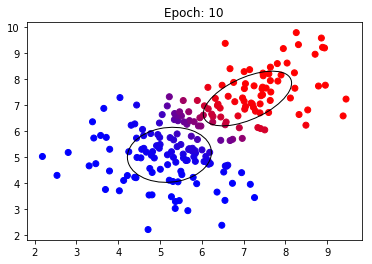

log_likelihood: -3.202136853679623


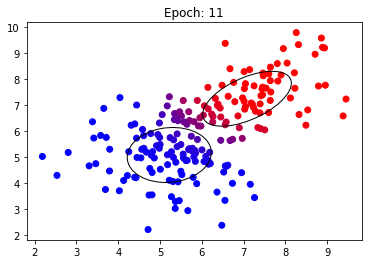

log_likelihood: -3.2048057736184794


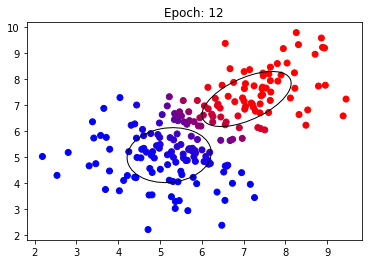

log_likelihood: -3.207363401906341


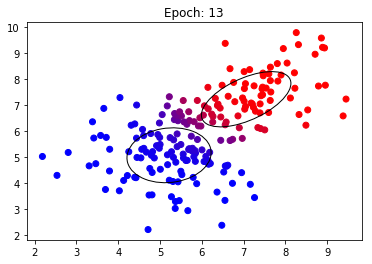

log_likelihood: -3.2098170653410065


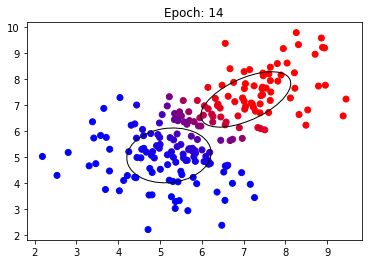

log_likelihood: -3.2121729155395156


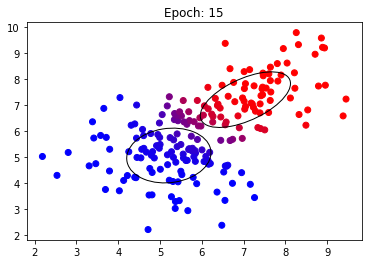

log_likelihood: -3.2144360363525113


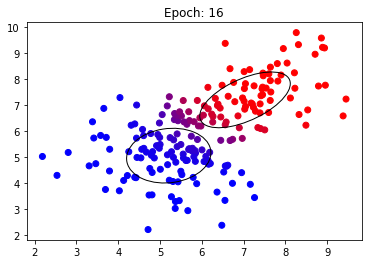

log_likelihood: -3.216610665418097


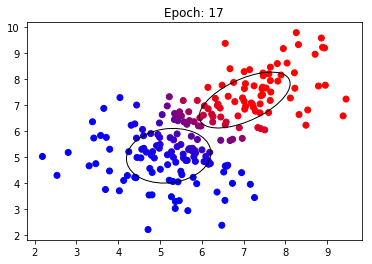

log_likelihood: -3.2187004155933496


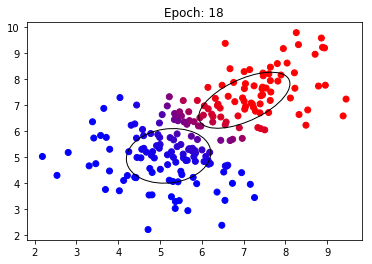

log_likelihood: -3.2207084572029268


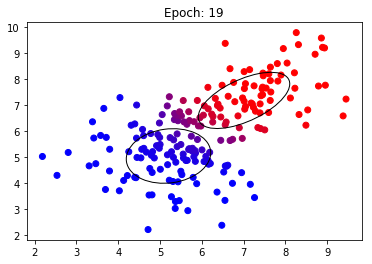

log_likelihood: -3.2226376546191022


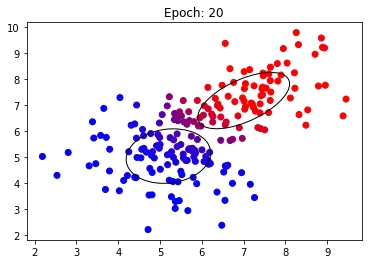

log_likelihood: -3.2244906629178876


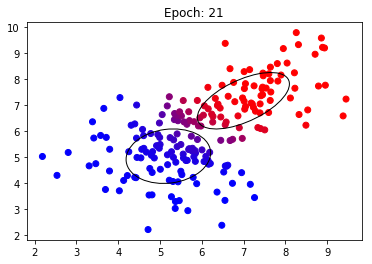

log_likelihood: -3.2262699935113153


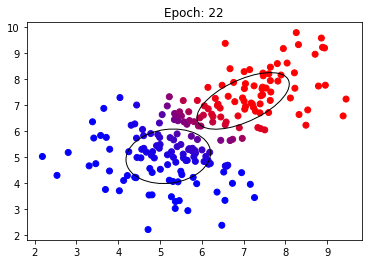

log_likelihood: -3.2279780571811982


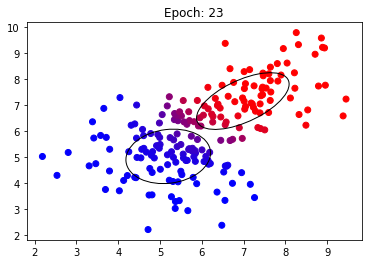

log_likelihood: -3.2296171913207647


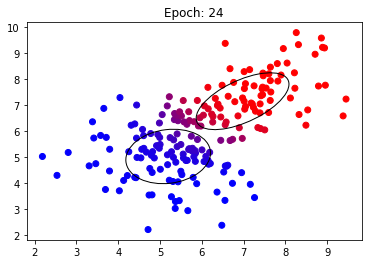

log_likelihood: -3.2311896764674017


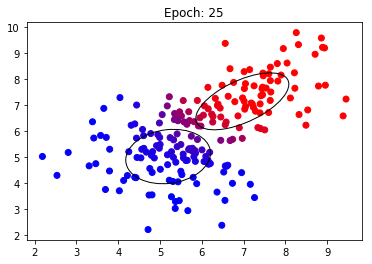

log_likelihood: -3.232697745750789


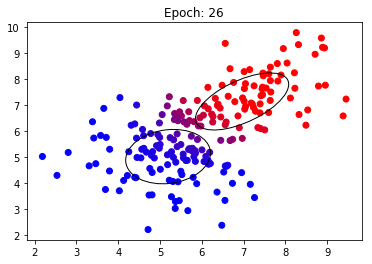

log_likelihood: -3.2341435897638235


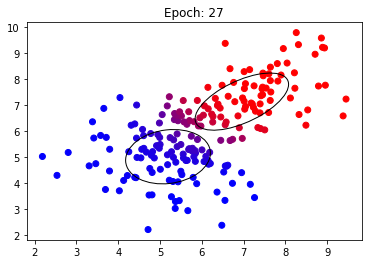

log_likelihood: -3.235529358554463


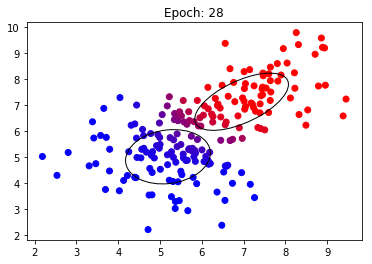

log_likelihood: -3.236857161870438


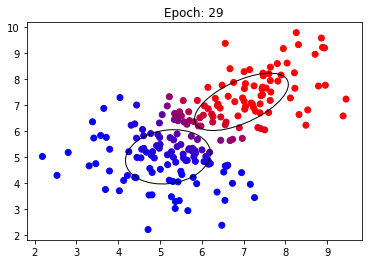

log_likelihood: -3.2381290684013657


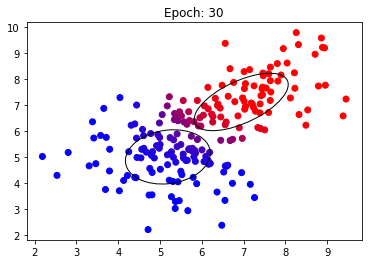

log_likelihood: -3.2393471045018574


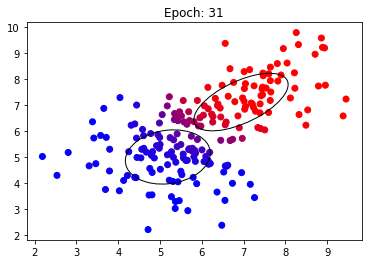

log_likelihood: -3.2405132527052487


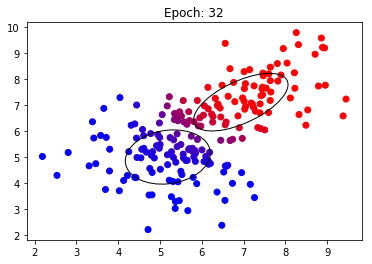

log_likelihood: -3.241629450222361


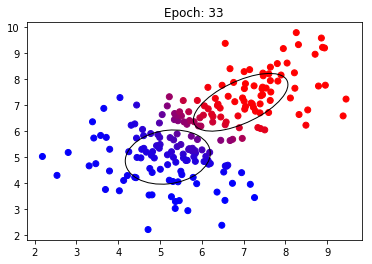

log_likelihood: -3.2426975875440145


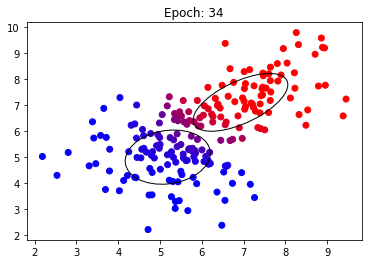

log_likelihood: -3.2437195072163716


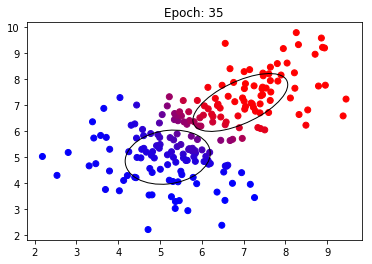

log_likelihood: -3.244697002825625


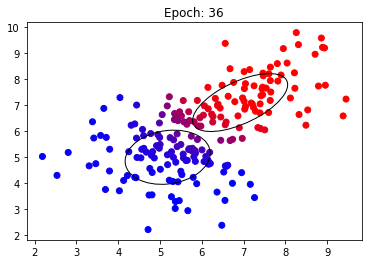

log_likelihood: -3.2456318182076176


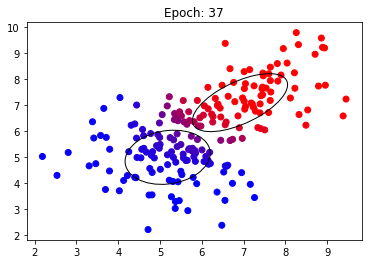

log_likelihood: -3.2465256468844865


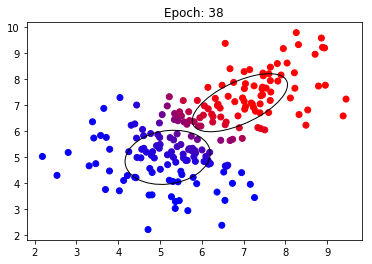

log_likelihood: -3.2473801317216573


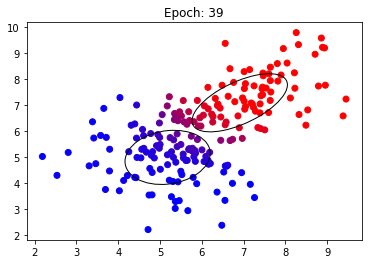

log_likelihood: -3.248196864793538


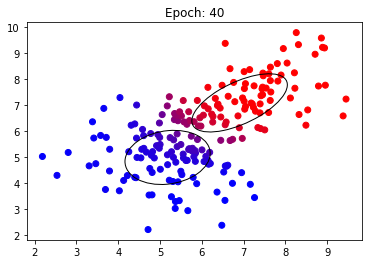

log_likelihood: -3.2489773874428223


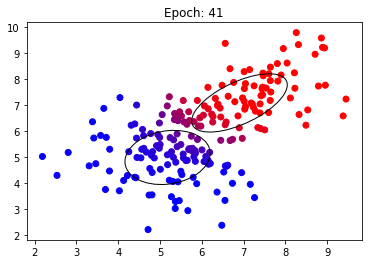

log_likelihood: -3.2497231905170665


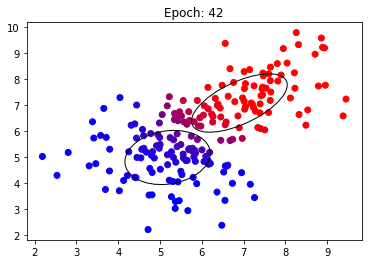

log_likelihood: -3.2504357147652545


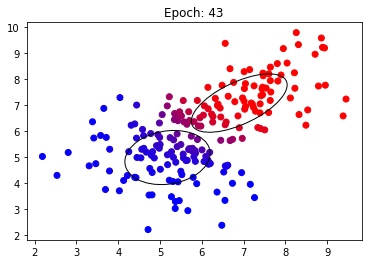

log_likelihood: -3.2511163513771986


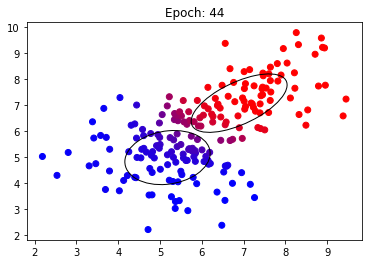

log_likelihood: -3.251766442649139


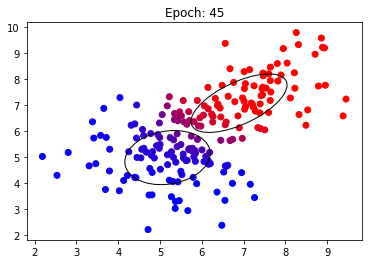

log_likelihood: -3.252387282759421


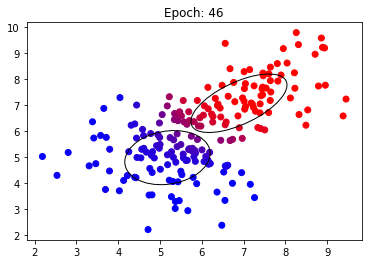

log_likelihood: -3.2529801186391385


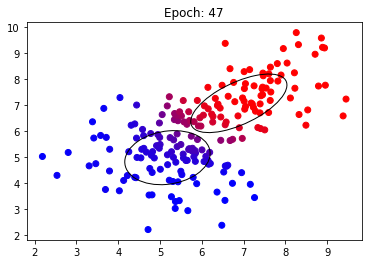

log_likelihood: -3.2535461509237833


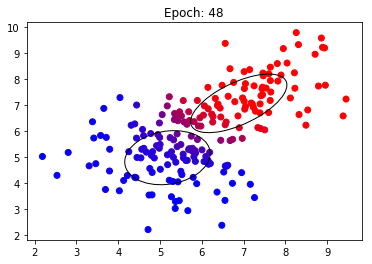

log_likelihood: -3.254086534972541


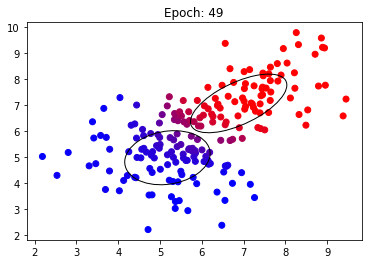

log_likelihood: -3.2546023819434104


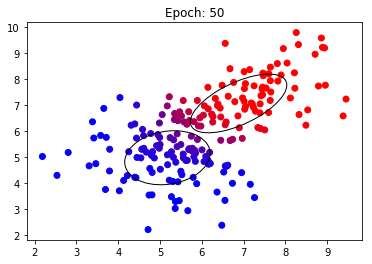

log_likelihood: -3.2550947599131


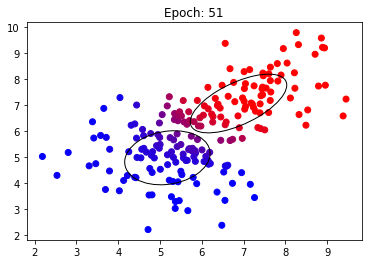

log_likelihood: -3.2555646950317496


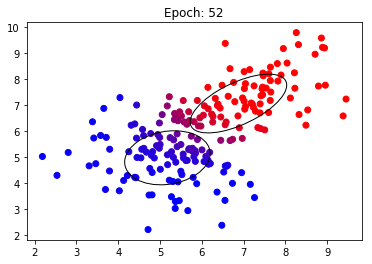

log_likelihood: -3.256013172703402


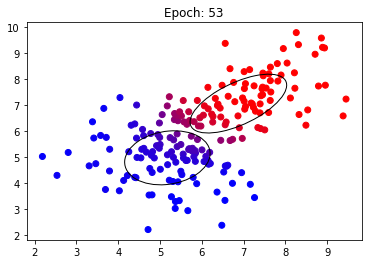

log_likelihood: -3.256441138784218


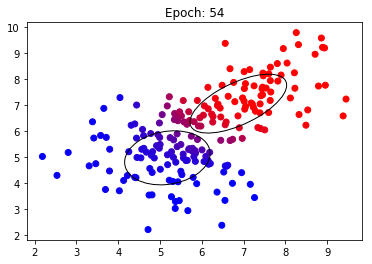

log_likelihood: -3.256849500791341


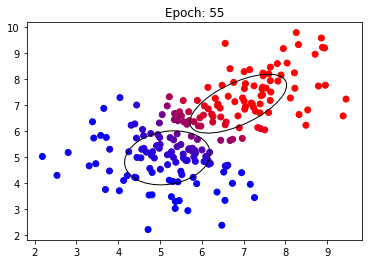

log_likelihood: -3.25723912911579


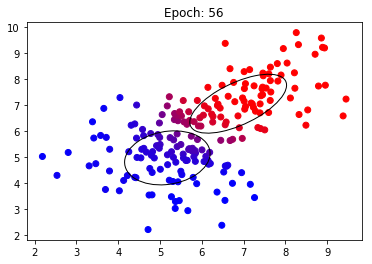

log_likelihood: -3.2576108582338845


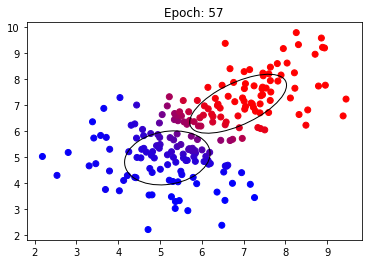

log_likelihood: -3.257965487912354


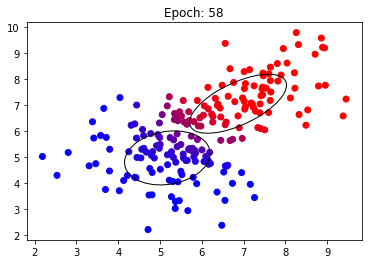

log_likelihood: -3.2583037844026403


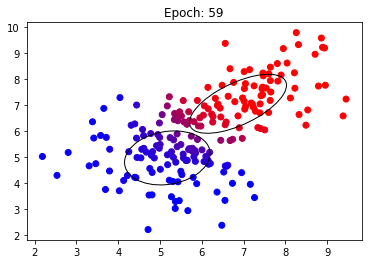

log_likelihood: -3.2586264816207873


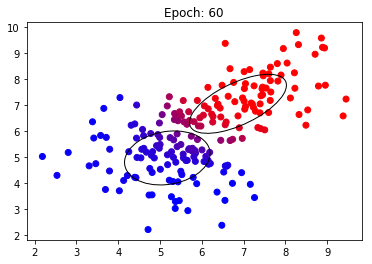

log_likelihood: -3.258934282309777


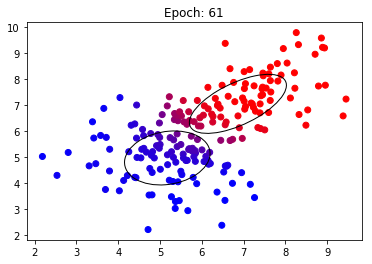

log_likelihood: -3.259227859181474


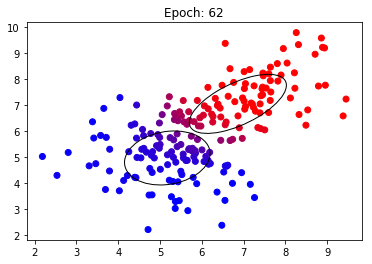

log_likelihood: -3.259507856036123


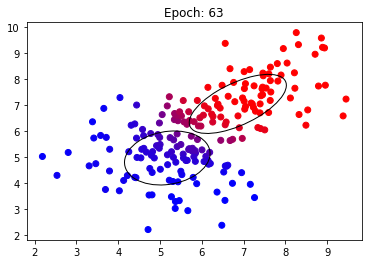

log_likelihood: -3.2597748888572706


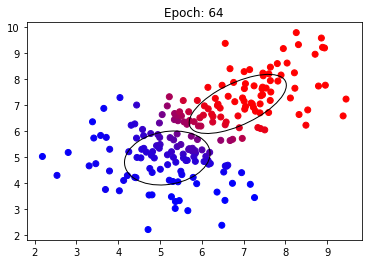

log_likelihood: -3.2600295468808556


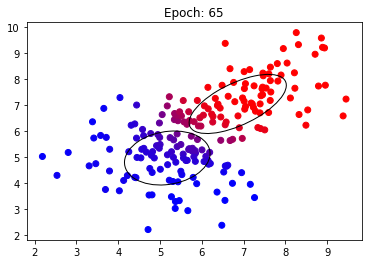

log_likelihood: -3.2602723936370324


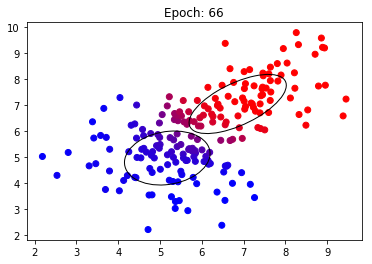

log_likelihood: -3.260503967963986


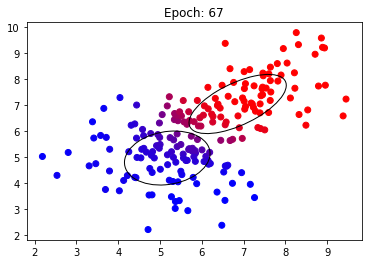

log_likelihood: -3.2607247849929255


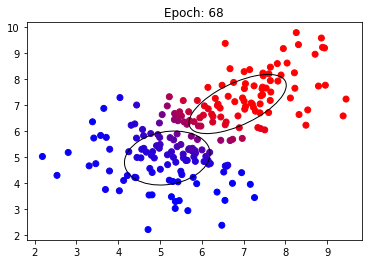

log_likelihood: -3.2609353371038643


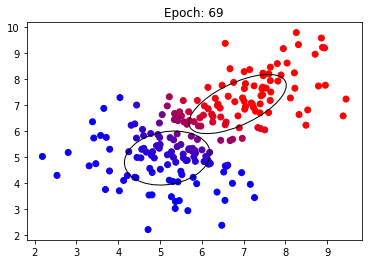

log_likelihood: -3.261136094851896


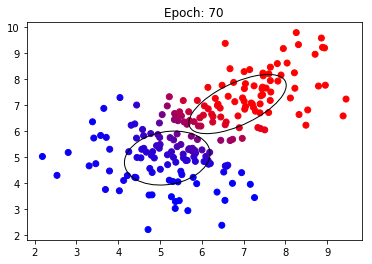

log_likelihood: -3.2613275078638533


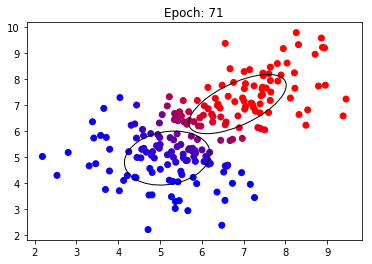

log_likelihood: -3.261510005705422


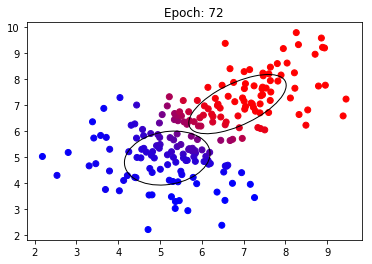

log_likelihood: -3.2616839987188677


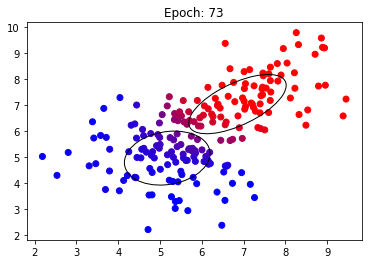

log_likelihood: -3.2618498788315935


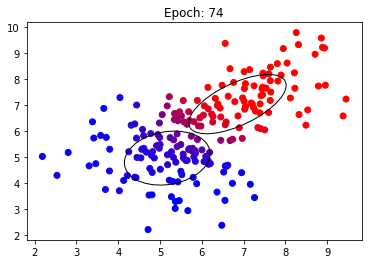

log_likelihood: -3.2620080203360726


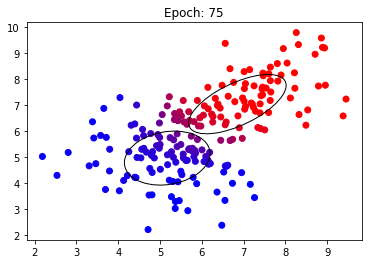

log_likelihood: -3.2621587806413395


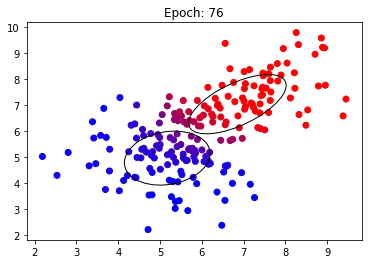

log_likelihood: -3.262302500996817


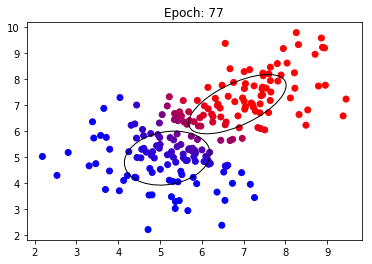

log_likelihood: -3.262439507188905


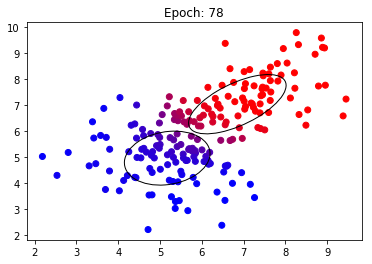

log_likelihood: -3.2625701102109375


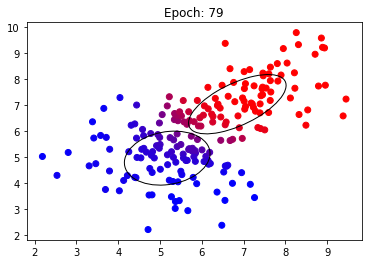

log_likelihood: -3.2626946069072544


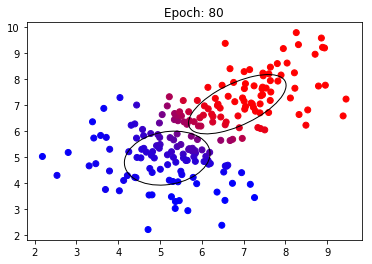

log_likelihood: -3.26281328059199


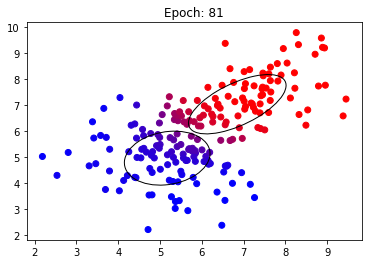

log_likelihood: -3.262926401643267


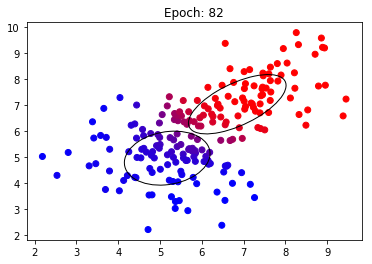

log_likelihood: -3.263034228073572


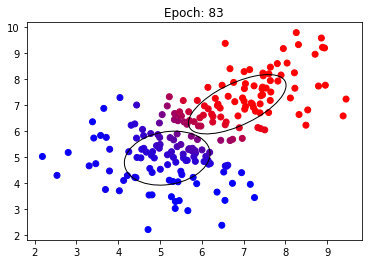

log_likelihood: -3.2631370060770126


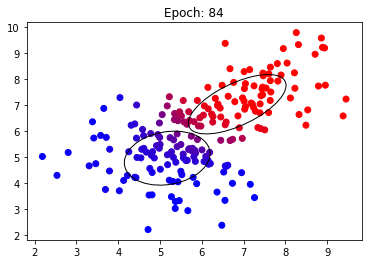

log_likelihood: -3.263234970554125


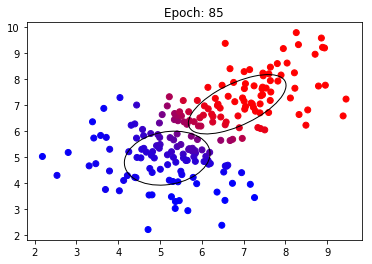

log_likelihood: -3.26332834561506


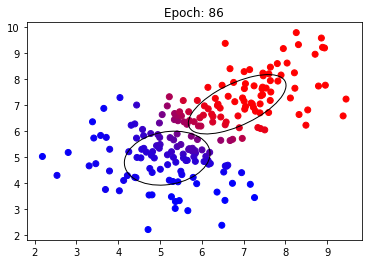

log_likelihood: -3.2634173450618107


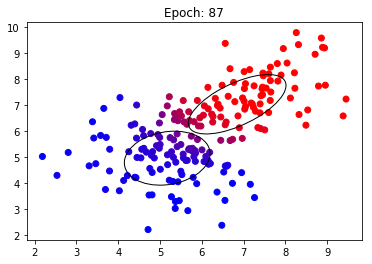

log_likelihood: -3.2635021728501763


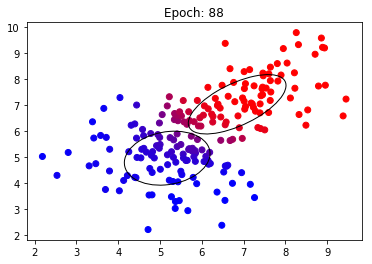

log_likelihood: -3.2635830235322736


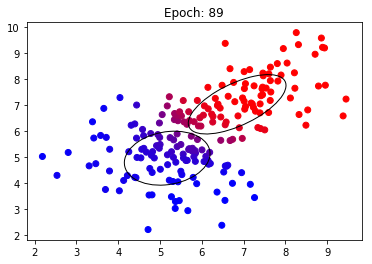

log_likelihood: -3.263660082680223


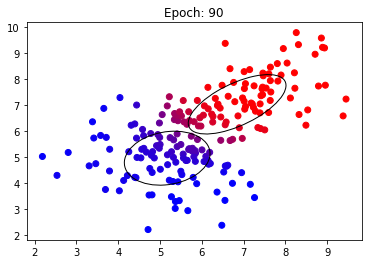

log_likelihood: -3.263733527291663


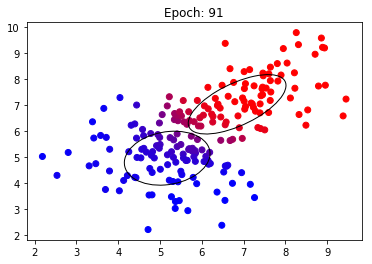

log_likelihood: -3.263803526177913


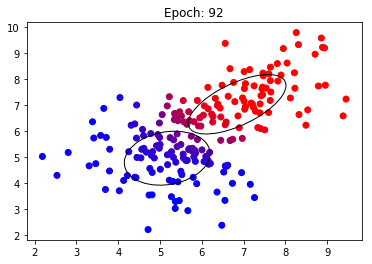

log_likelihood: -3.263870240335274


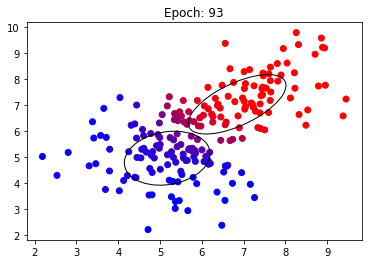

log_likelihood: -3.263933823300243


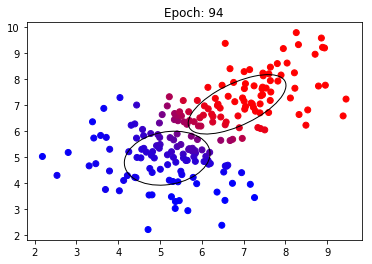

log_likelihood: -3.263994421489202


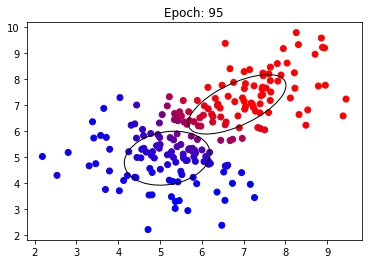

log_likelihood: -3.264052174523212


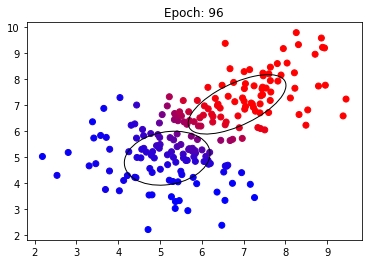

log_likelihood: -3.2641072155385706


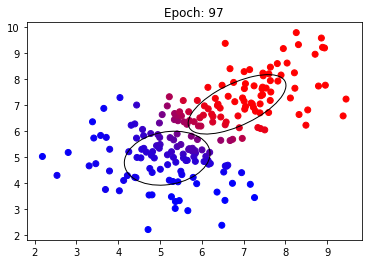

log_likelihood: -3.2641596714835233


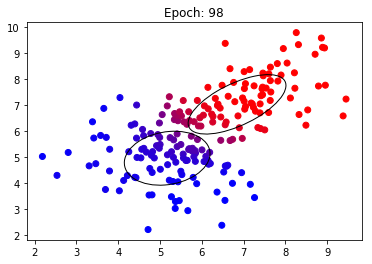

log_likelihood: -3.264209663401984


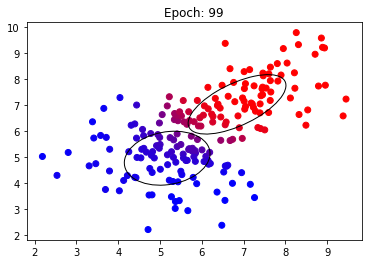

log_likelihood: -3.264257306704448


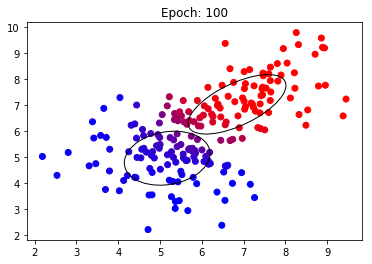

log_likelihood: -3.264302711427011


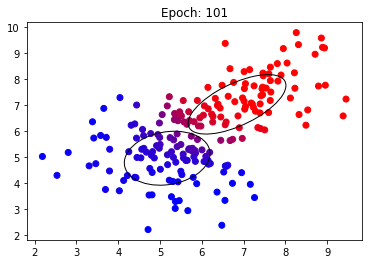

log_likelihood: -3.2643459824786496


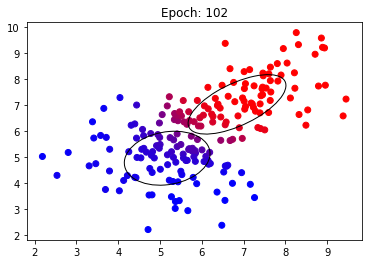

log_likelihood: -3.264387219877445


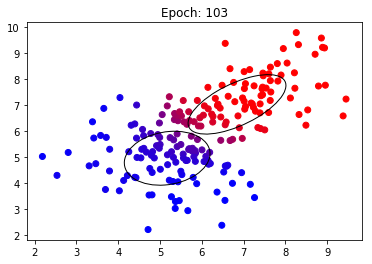

log_likelihood: -3.264426518976212


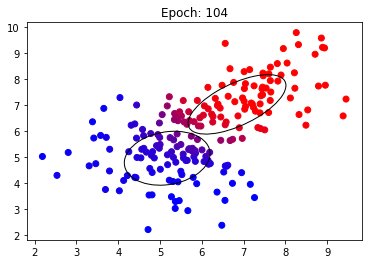

log_likelihood: -3.2644639706778995


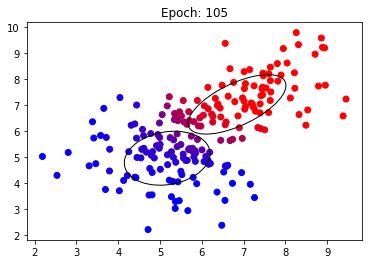

log_likelihood: -3.264499661641302


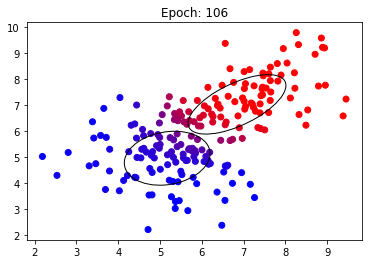

log_likelihood: -3.2645336744774114


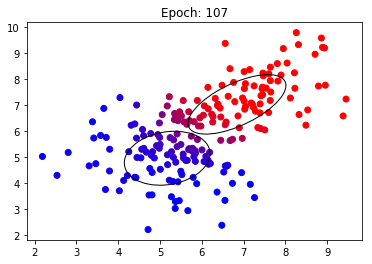

log_likelihood: -3.2645660879368763


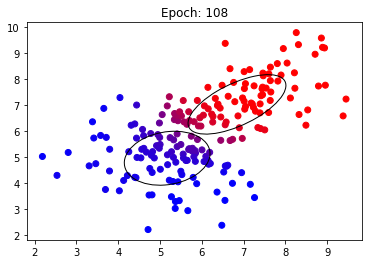

log_likelihood: -3.2645969770889036


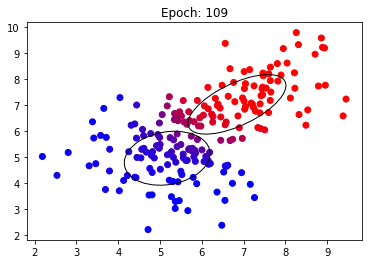

log_likelihood: -3.2646264134920684


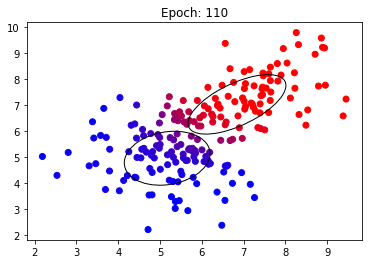

log_likelihood: -3.2646544653572676


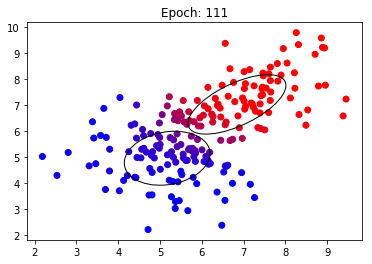

log_likelihood: -3.2646811977032253


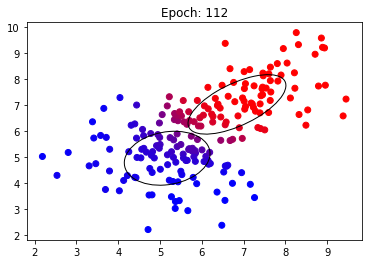

log_likelihood: -3.2647066725049227


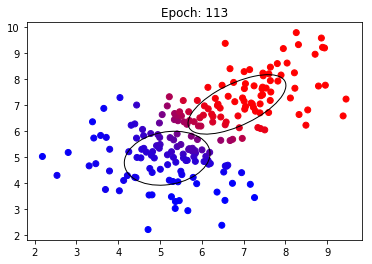

log_likelihood: -3.2647309488351897


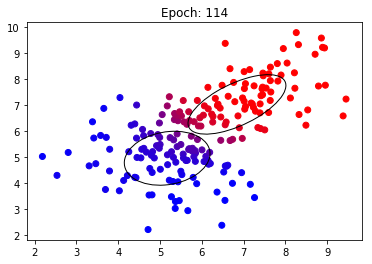

log_likelihood: -3.264754082999767


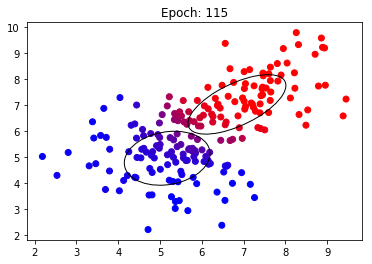

log_likelihood: -3.264776128666227


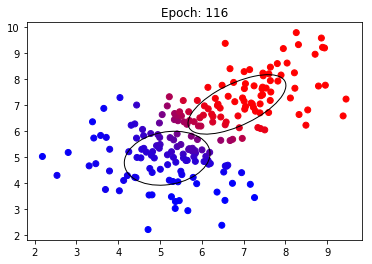

log_likelihood: -3.2647971369868847


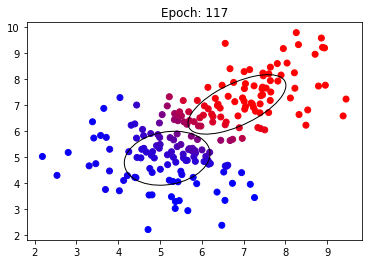

log_likelihood: -3.2648171567161106


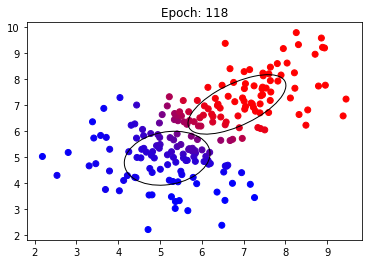

log_likelihood: -3.26483623432216


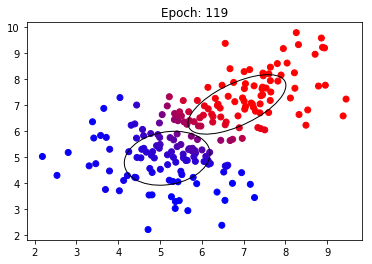

log_likelihood: -3.2648544140939055


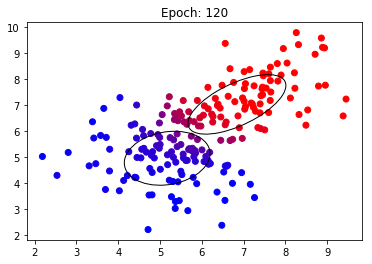

log_likelihood: -3.264871738242582


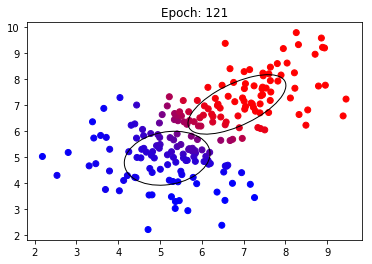

log_likelihood: -3.2648882469988685


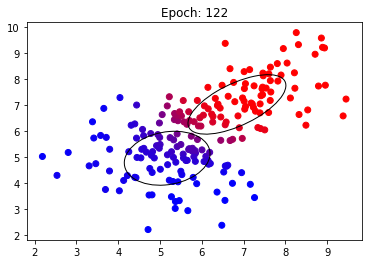

log_likelihood: -3.264903978705413


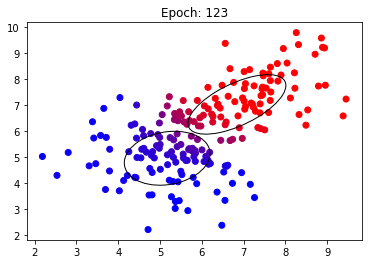

log_likelihood: -3.264918969905137


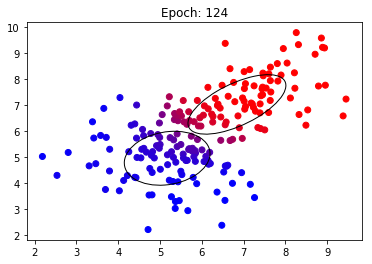

log_likelihood: -3.264933255425363


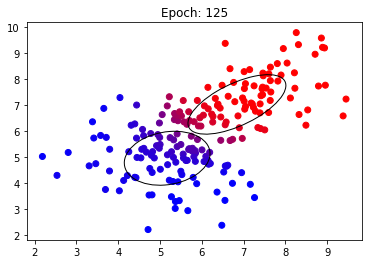

log_likelihood: -3.264946868458158


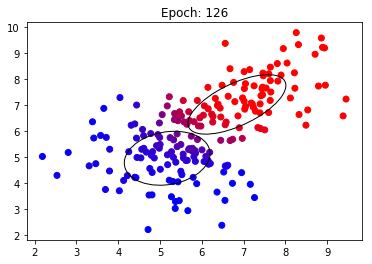

log_likelihood: -3.264959840636762


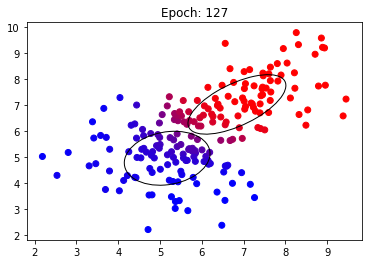

log_likelihood: -3.2649722021086753


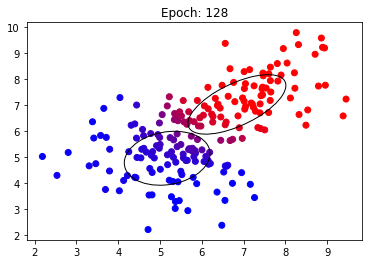

log_likelihood: -3.2649839816051625


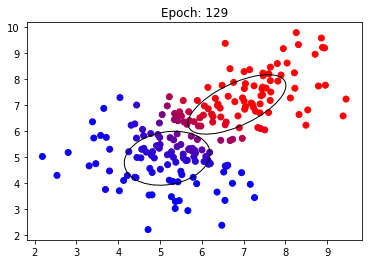

log_likelihood: -3.2649952065076286


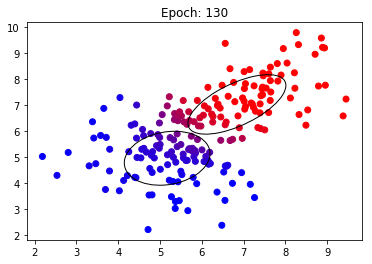

log_likelihood: -3.265005902910836


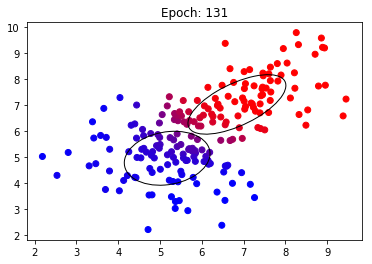

log_likelihood: -3.265016095683281


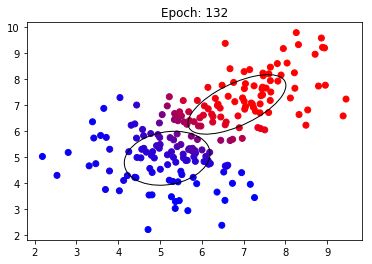

log_likelihood: -3.265025808524602


In [18]:
cluster1 = gaussian_params([5,5], [[1, 0], [0, 1]], 100)
cluster2 = gaussian_params([7,7], [[1, .5], [.6, 1]], 100)
params = [cluster1, cluster2]

data = get_data(params)
EM(data, 2)

log_likelihood: -5.697551420111979
log_likelihood: -5.709168814705931
log_likelihood: -5.690161731982332
log_likelihood: -5.561224965928875
log_likelihood: -5.182624500990581
log_likelihood: -4.401050215395285
log_likelihood: -4.397662146278277
log_likelihood: -4.397662146278277


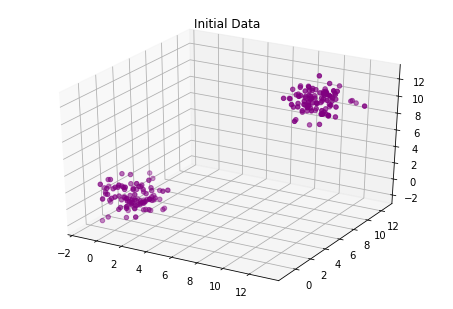

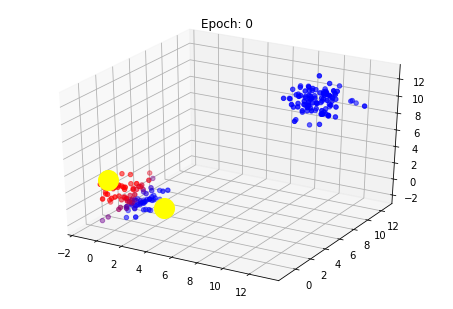

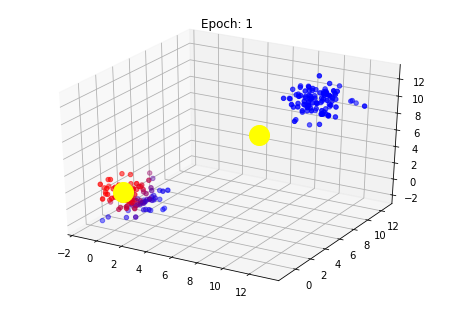

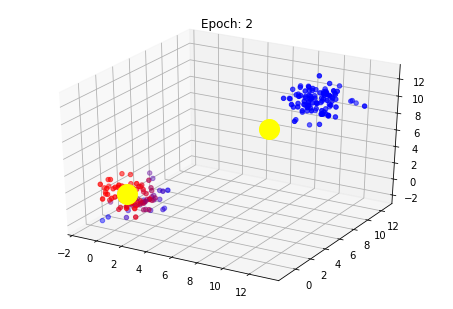

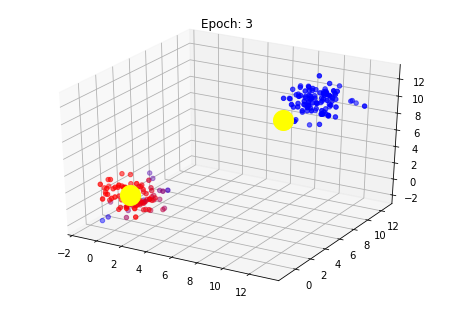

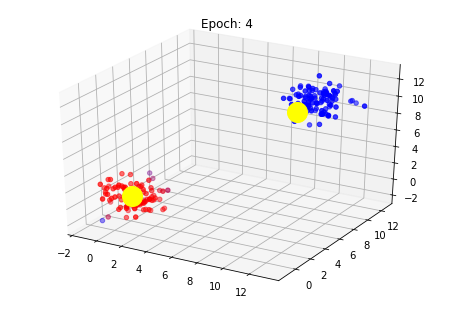

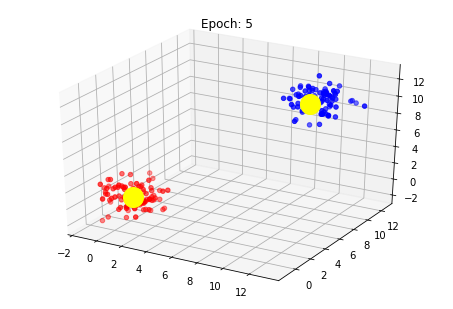

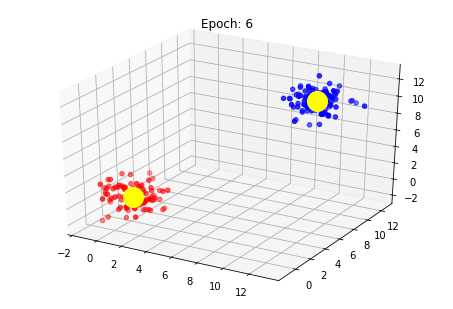

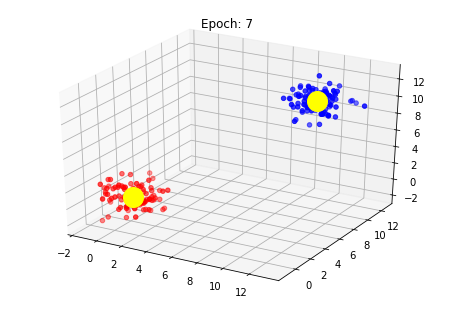

In [22]:
cluster1 = gaussian_params(np.array([1, 1, 1]), np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), 100)
cluster2 = gaussian_params(np.array([10, 10, 10]), np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), 100)
params = [cluster1, cluster2]

data = get_data_3d(params)
EM_3d(data, 2)

## Test py file implementation

In [26]:
from importlib import reload
import EM
import helper
from helper import plot_cluster

reload(EM)
reload(helper)

<module 'helper' from '/datasets/home/23/823/hal009/fitbitEM/helper.py'>

In [6]:
cluster1 = gaussian_params([1,1], [[1, 0], [0, 1]], 100)
cluster2 = gaussian_params([10,10], [[1, 0], [0, 1]], 100)
params = [cluster1, cluster2]

data = get_data(params)

In [7]:
em = EM.EM(data, 2)
(mu, sigma, pi) = em.initialize_params()

In [81]:
print(mu)
print(sigma)
print(pi)

[[ 9.76853998 11.3934349 ]
 [ 1.00997637  2.59411234]]
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
[0.5 0.5]


In [82]:
em.eval_log_likelihood(mu, sigma, pi)

-8.238541882429022

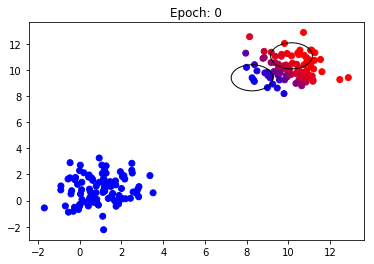

In [14]:
gamma = em.E_step(mu, sigma, pi)
plot_cluster(data, mu, sigma, gamma, 0)

In [95]:
(mu_hat, sigma_hat, pi_hat) = em.execute()

In [96]:
em.eval_log_likelihood(mu_hat, sigma_hat, pi_hat)

-5.847468614851439

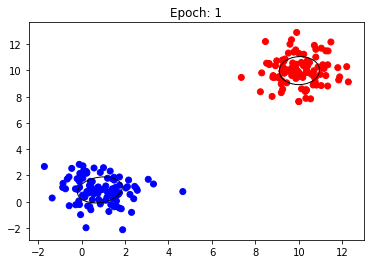

In [101]:
gamma = em.E_step(mu_hat, sigma_hat, pi_hat)
plot_cluster(data, mu_hat, sigma_hat, gamma, 1)

In [38]:
cluster1 = gaussian_params(np.array([1000, 1000, 1000]), np.array([[1000, 0, 0], [0, 1000, 0], [0, 0, 1000]]), 100)
cluster2 = gaussian_params(np.array([10000, 10000, 10000]), np.array([[1000, 0, 0], [0, 1000, 0], [0, 0, 1000]]), 100)
params = [cluster1, cluster2]

data_3d = get_data_3d(params)

In [39]:
em = EM.EM(data_3d, 2)
(mu, sigma, pi) = em.initialize_params()

In [40]:
print(mu)
print(sigma)
print(pi)

[[ 994.71134737 1042.00412515 1033.45160496]
 [ 963.62317613 1041.16595424 1043.20800799]]
[[[10000.     0.     0.]
  [    0. 10000.     0.]
  [    0.     0. 10000.]]

 [[10000.     0.     0.]
  [    0. 10000.     0.]
  [    0.     0. 10000.]]]
[0.5 0.5]


In [30]:
em.eval_log_likelihood(mu, sigma, pi)

-16.577734877444442

In [41]:
gamma = em.E_step(mu, sigma, pi)

/datasets/home/23/823/hal009/fitbitEM/EM.py:53: RuntimeWarning: invalid value encountered in true_divide
  gamma_z /= gamma_z.sum(0)


/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


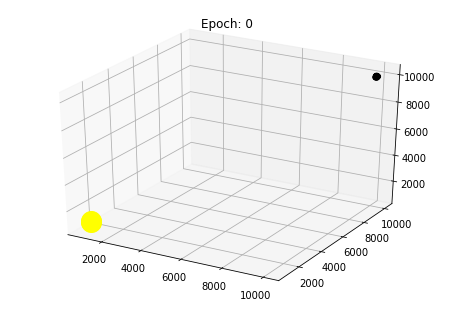

In [42]:
plot_cluster_3d(data_3d, mu, sigma, gamma, 0)

In [36]:
(mu_hat, sigma_hat, pi_hat) = em.execute()

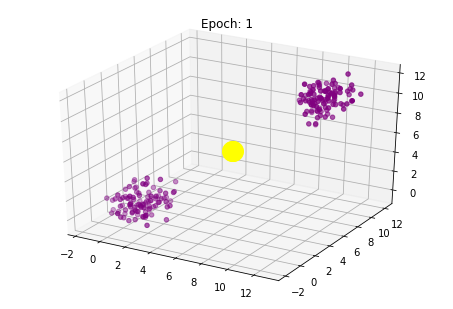

In [37]:
gamma = em.E_step(mu_hat, sigma_hat, pi_hat)
plot_cluster_3d(data_3d, mu_hat, sigma_hat, gamma, 1)